In [27]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import ast
from keplergl import KeplerGl

## Datasets
1. Kinki area origin and destination dataset
2. Myanmar 2014 census dataset

## Origin and destination visualization

In [28]:
# loading in the dataset
odf = gpd.read_file("data/kinki/S05-b-12_KINKI_GML/S05-b-12_KINKI-g_PersonTripODAmount.shp")
odf.head()

,S05b_001,S05b_002,S05b_003,S05b_004,S05b_005,S05b_006,S05b_007,S05b_008,S05b_009,S05b_010,...,S05b_039,S05b_040,S05b_041,S05b_042,S05b_043,S05b_044,S05b_045,S05b_046,S05b_047,geometry
0,2,2010,11110,11110,104,39,181,109,292,725,...,9421,20936,0,0,66,26,12,104,67085,"LINESTRING (135.85563 35.18815, 135.85593 35.1..."
1,2,2010,11110,11120,211,434,142,105,341,1233,...,0,21,0,0,0,0,0,0,6077,"LINESTRING (135.85563 35.18815, 135.85366 35.0..."
2,2,2010,11110,11130,646,77,312,88,42,1165,...,0,0,0,0,46,0,0,46,3049,"LINESTRING (135.85563 35.18815, 135.85055 35.0..."
3,2,2010,11110,11140,111,584,124,41,136,996,...,0,0,0,0,0,0,0,0,2392,"LINESTRING (135.85563 35.18815, 135.88046 34.9..."
4,2,2010,11110,11150,0,50,0,0,18,68,...,0,0,0,0,0,0,0,0,235,"LINESTRING (135.85563 35.18815, 135.90900 34.9..."


In [29]:
# year, origin code, destination code, total train trips count, total trips count, geometry
odf[['S05b_002', 'S05b_003', 'S05b_004', 'S05b_010', 'S05b_035', 'geometry']]

,S05b_002,S05b_003,S05b_004,S05b_010,S05b_035,geometry
0,2010,11110,11110,725,751,"LINESTRING (135.85563 35.18815, 135.85593 35.1..."
1,2010,11110,11120,1233,0,"LINESTRING (135.85563 35.18815, 135.85366 35.0..."
2,2010,11110,11130,1165,0,"LINESTRING (135.85563 35.18815, 135.85055 35.0..."
3,2010,11110,11140,996,0,"LINESTRING (135.85563 35.18815, 135.88046 34.9..."
4,2010,11110,11150,68,0,"LINESTRING (135.85563 35.18815, 135.90900 34.9..."
...,...,...,...,...,...,...
186619,2010,91230,51840,0,0,"LINESTRING (135.19212 34.03233, 135.47042 34.6..."
186620,2010,91230,11210,0,0,"LINESTRING (135.19212 34.03233, 135.95156 35.0..."
186621,2010,91230,61130,0,0,"LINESTRING (135.19212 34.03233, 135.38993 34.7..."
186622,2010,91230,63320,0,0,"LINESTRING (135.19212 34.03233, 134.92020 34.6..."


In [30]:
# http://nlftp.mlit.go.jp/ksj/gml/codelist/KinkiAreaZoneCd.html

In [31]:
# kobe data
kobe = odf.query('S05b_003 == "71110"')
len(kobe)

432

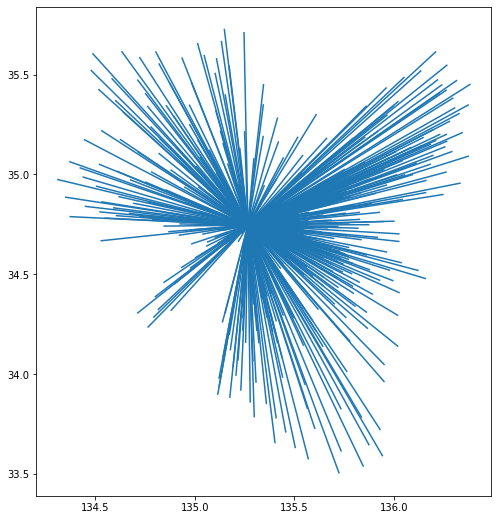

In [32]:
kobe.plot(figsize=(15,9));

In [33]:
# retain only necessary columns
odf_necessary = odf[['S05b_003', 'S05b_004',  'S05b_010', 'S05b_035', 'geometry']]
odf_necessary.columns = ['zone01', 'zone02', 'trip_train', 'trip_all', 'geometry']
odf_necessary.head()

,zone01,zone02,trip_train,trip_all,geometry
0,11110,11110,725,751,"LINESTRING (135.85563 35.18815, 135.85593 35.1..."
1,11110,11120,1233,0,"LINESTRING (135.85563 35.18815, 135.85366 35.0..."
2,11110,11130,1165,0,"LINESTRING (135.85563 35.18815, 135.85055 35.0..."
3,11110,11140,996,0,"LINESTRING (135.85563 35.18815, 135.88046 34.9..."
4,11110,11150,68,0,"LINESTRING (135.85563 35.18815, 135.90900 34.9..."


### extract latitude and longitude of the Origin & Destination

In [34]:
odf_lat_long = odf_necessary.assign(
    lng_to=lambda odf_necessary: odf_necessary.apply(lambda row: row['geometry'].xy[0][0], axis=1) ,
    lng_from=lambda odf_necessary: odf_necessary.apply(lambda row: row['geometry'].xy[0][1], axis=1) ,
    lat_to=lambda odf_necessary: odf_necessary.apply(lambda row: row['geometry'].xy[1][0], axis=1) ,
    lat_from=lambda odf_necessary: odf_necessary.apply(lambda row: row['geometry'].xy[1][1], axis=1) 
)

In [35]:
odf_lat_long.head()

,zone01,zone02,trip_train,trip_all,geometry,lng_to,lng_from,lat_to,lat_from
0,11110,11110,725,751,"LINESTRING (135.85563 35.18815, 135.85593 35.1...",135.855629,135.855929,35.188154,35.188454
1,11110,11120,1233,0,"LINESTRING (135.85563 35.18815, 135.85366 35.0...",135.855629,135.853661,35.188154,35.062414
2,11110,11130,1165,0,"LINESTRING (135.85563 35.18815, 135.85055 35.0...",135.855629,135.850548,35.188154,35.005337
3,11110,11140,996,0,"LINESTRING (135.85563 35.18815, 135.88046 34.9...",135.855629,135.880463,35.188154,34.978670
4,11110,11150,68,0,"LINESTRING (135.85563 35.18815, 135.90900 34.9...",135.855629,135.908997,35.188154,34.905859


In [38]:
# reading in the kepler config file
keplerconfig = open("config/kepler_config.txt").read()

In [39]:
keplerconfig

"{'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '4hj0mq', 'type': 'arc', 'config': {'dataId': 'personTripOD', 'label': 'personTripOD', 'color': [225, 49, 106], 'columns': {'lat0': 'lat_from', 'lng0': 'lng_from', 'lat1': 'lat_to', 'lng1': 'lng_to'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'thickness': 1, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'sizeRange': [0, 1], 'targetColor': [207, 216, 244]}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': {'name': 'trip_train', 'type': 'integer'}, 'sizeScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'personTripOD': ['S05b_003', 'S05b_004', 'S05b_035']}, 'enabled': False}, 'brush': {'size': 1.1, 'enabled': True}

In [40]:
map_personTripOD_curve = KeplerGl(height=600, config=ast.literal_eval(keplerconfig))
map_personTripOD_curve.add_data(data=odf_lat_long, name='ODTrip')
map_personTripOD_curve

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '4hj0mq', 'type': '…

In [46]:
map_personTripOD_curve.save_to_html(file_name="TripOD_map.html")

Map saved to TripOD_map.html!


In [42]:
map_personTripOD_curve.config

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'iskiu19',
     'type': 'arc',
     'config': {'dataId': 'ODTrip',
      'label': 'ODTrip',
      'color': [18, 92, 119],
      'columns': {'lat0': 'lat_from',
       'lng0': 'lng_from',
       'lat1': 'lat_to',
       'lng1': 'lng_to'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'lin

In [45]:
# saving the current kepler settings
# Note, if you didnt change the rendered output, you dont need to run this cell
with open("config/kepler_config.txt",'w') as kepler_config_file:
    kepler_config_file.write(str(map_personTripOD_curve.config))

### Myanmar census dataset